# Movie Review

The goal of this project is to analyse IMDB movie reviews texts using various NLP techniques and libraries. A dataset that we are going to use is ment mainly for binary sentiment classification and perform this particular type of analysis will, indeed, be our primary goal, but additionaly we'll use POS tagging to find commonly used nown and verb phrases, find the most common movie themes and topics users wrote about, determine how similar various users’ texts are (by topic, vocabulary use and Levenshtein distance) and, finally, create frequency distributions for key words/phrases. 

Thanks to authors of this dataset it contains substantially more data than previous benchmark datasets. They provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. In this regard, I respectfully would like to draw your attention to their research paper: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015) (Maas et al., ACL 2011)

## EDA

Let's import necessary libraries and methods crucial for further work and look at our dataset. We are going to upload data via `pandas` to see if it would facilitate further analysis.

In [1]:
import pandas as pd
import os
import pickle
import re, nltk
from nltk import pos_tag_sents, RegexpParser
from nltk import word_tokenize, sent_tokenize
from IPython.display import display
from nltk.corpus import stopwords

Note: we are going to use `pickle` to speed up running time of certain cells after restart of a Kernel, so in some cells will be placed `pickle` functions. 

In [2]:
def pickle_object(object, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(object, f)

def unpickle_object(file_path):
    if not os.path.isfile(file_path):
        return None
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def with_pickle(file_path, fun):
    value = unpickle_object(file_path)
    if value is None:
        value = fun()
        pickle_object(value, file_path)
    return value

Now let's upload data into `pandas` DataFrame and see first several rows. 

In [3]:
movie_reviews = pd.read_csv('imdb_dataset.csv')
# Display full length text in column
pd.options.display.max_colwidth = None
movie_reviews.head(5)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

Reviews text is medium length and does not look too noisy from the first glance. We see some HTML tags and that's basically it for the first few texts. We are going to check in depth some other "noise issues" of this text, but let's first check how many positive and negative reviews this dataset contains exactly. 

In [4]:
(movie_reviews.sentiment =='negative').sum()

25000

In [5]:
(movie_reviews.sentiment =='positive').sum() 

25000

In [6]:
len(movie_reviews)

50000

So, of 50 thousand reviews exactly half marked as "negative" and the other half as "positive". Considering, there are only 2 columns in this DataFrame, which are "review" texts themselves and their "sentiment", there is not much quck insights we can get out of the dataset without applying NLP methods, so let's get to noise removal part.

## Noise Removal

We'll start with pretty standart noise removal:
- HTML tags;
- Links.

In [7]:
def remove_html_tags():
    movie_reviews.review = movie_reviews.review.str.replace(r'<br />|</?(i|p|em|hr)|', '', regex=True)
    return movie_reviews

# Remove HTML tags
movie_reviews = with_pickle('pickles/html_tags_removed.pickle', remove_html_tags)

In [8]:
# Remove links
movie_reviews.review = movie_reviews.review.str.replace(r'''[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)''', '', regex=True)

To check the results after applying our nose removal `regex` expressions and find other different flaws of this dataset we'll use pretty sophysticated codesnippet from StackOverflow which highlights user entered strings or regex expressions. 

Using this method we may not only check data for noise, but also find some interesting text properties, like `emoticons`. There is a huge ammount of valuable sentiment information hidden withing these symbols, yet not many public libraries are capable of their efficient interpretation. After some reseach of available libraries I decided to leave these symbols as they are, but in the future it could be benificial to "translate" them to text strings, meaningful for text processing algorithms. There are some examples of text containing different types of `emoticons` below. 

In [9]:
from IPython.display import HTML
def display_highlighted_words(df, keywords):
    head = """
    <table>
        <thead>
            """ + \
            "".join(["<th> %s </th>" % c for c in df.columns])\
            + """
        </thead>
    <tbody>"""

    for i,r in df.iterrows():
        row = "<tr>"
        for c in df.columns:
            matches = []
            for k in keywords:
                for match in re.finditer(k, str(r[c])):
                    matches.append(match)
        
            # reverse sorting
            matches = sorted(matches, key = lambda x: x.start(), reverse=True)
        
            # building HTML row
            cell = str(r[c])
            for match in matches:
                cell = cell[:match.start()] +\
                    "<span style='color:red;'>%s</span>" % cell[match.start():match.end()] +\
                    cell[match.end():]
            row += "<td> %s </td>" % cell
                
            row += "</tr>"
        head += row

    head += "</tbody></table>"
    display(HTML(head))

display_highlighted_words(movie_reviews[movie_reviews.review.str.contains(r':-\)')][:2], [':-\)'])


"I have to say that this miniseries was the best interpretation of the beloved novel ""Jane Eyre"". Both Dalton and Clarke are very believable as Rochester and Jane. I've seen other versions, but none compare to this one. The best one for me. I could never imagine anyone else playing these characters ever again. The last time I saw this one was in 1984 when I was only 13. At that time, I was a bookworm and I had just read Charlotte Bronte's novel. I was completely enchanted by this miniseries and I remember not missing any of the episodes. I'd like to see it again because it's so good. :-)",positive
"This was one of my favorite series when I was a kid. The Swedish broadcasting company decided to broadcast it once again a couple of summers ago when I had just finished my first semester of medical school. I was surprised to see the depth in which the organs was explained. Sure, some things are simplified but most of it was correct (even though it was made 22 years ago!) and quite understandable. I would suggest that all soon-to-be medical student should watch it. It is a very good way to learn some of the basic medical words for example. Now I'm in my 7th semester and I think I'll watch the series once again as soon as I've bought the DVD-box :-)",positive


In [10]:
display_highlighted_words(movie_reviews[movie_reviews.review.str.contains(r'\^_+')][2:7], ['_', '\^', '-', '~', '='])

"Since the last horrid Astérix film and the fact that we only get the Swiss German version in cinemas, here, I went to watch it with quite a bit of trepidation... Unfounded, as I was happy to discover ^____^The film is funny and modern, has good gags, a good animation, an amusing character interaction, a good voice cast (Note: I can only speak for the Swiss German one!) except for the Viking chief's daughter Abba (her name is great, despite the not very inspired voice actress)...I especially liked the character Justforkix (Goudurix in French, Grautvornix in German. He's the young man who is supposed to be put in shape...). He's a very amusing portrayal of a mollycoddled, urban teenager; but he's very likable, despite the teenage mannerisms... XD The interaction between Astérix & Obélix and their young charge is fantastic and thoroughly entertaining.It shouldn't be compared to the old films, since this one is quite different... Which surprisingly doesn't make it bad. On the contrary. When they tried to modernize the last film (twelve years ago), they completely blew it. This film, however, proved that it can be done just fine... ^-^I came out of the theater cheerful... Always a good sign ^_~",positive
"Just finished watching the movie and wanted to give my own opinion(and justice) to the movie.First of all, to get things straight, this movie is not pretending to be anything other than a solid action comedy movie. It doesn't aim to revolutionize the movie industry and garner critical acclaims nor does it want to be regarded as one. If you really want to enjoy this movie to the fullest, I suggest you discard your critical-mindedness and your longing for a good plot because you won't find any in here. With that established, let us further into the movie.I had low expectations for this movie simply because it didn't have a strong plot(Yes, moviegoers, I underrated this movie as well), but I never expected myself to enjoy this movie that much. I even enjoyed this more than the Stephen Chow flicks(which I find Kung Fu Hustle to be his best effort and would've rated it a 9 as well). Action is tight and epic while comedy chokes on to the right places.SPOILERS alert, I think The action might be unreal, but why would I want to watch a serious basketball movie anyways? There are a lot other sports movies(drama) that already did it well, why create another? SPOILERS endI'm not even sure why you're reading this. Go ahead and watch it. Just remember, no thinking - just watch, enjoy, smile, laugh, and Every once in a while they(the movie industry) creates masterpieces such as Pulp Fiction or The Godfather movies, and sometimes they create movies which are better off in the pile of dump. I'm not saying Kung Fu Dunk deserves the recognition that the previous examples have, then again, if we're talking about Stephen Chow-ish comedy, this one's a top ten.Highly recommended if you love: -no brainer movies with really good action -Kung Fu -Death Trance -Kung Fu and comedy -what the heck, watch this. you'll have a great time.9/10 for you the cast of Kung Fu Dunk. ^_^",positive
"Susie Q. is one of those rare, and sweet movies that give you a warm feeling. It's bittersweet, but wholesome, and it's characters are fun, and captivating. At first, I thought the movie would be the cliché cuddly movie that would bore me after five minutes, but was I wrong. It made me tear up at times, and it's plot was enticing, making me root for the good guys. I loved the movie, and still remember it today, 9 years later!! I recommend it highly to ANYONE, and the movie is family oriented, so you won't have to worry about unsuitable content. Truly, if Disney would show more movies that are up to par as Susie Q., it would be the most popular family oriented channel in the world. Now if only Disney would show it just ONE more time!^_^ Go Susie Q.!!",positive
"Okay, this may not be the most sophisticated movie you'll ever see. Actually, there isn't a bit of ""sophisticatedlyn

Other interesting thing that is probably specific to reviews in general - users tend to give their personal score on the scale from 1 to 10, which can be a big help for machine learning algorithms if interpreted correctly. As well as `emoticons`, `user scores` are worth looking into on the further stages of algorithms tunning so I'll leave them in place with other digits for now, since they will not affect the first part of our analysis. 

## Pre-processing: phase 1

Now that we removed at least some noise we are going to apply text preprocessing methods. We are going to need part of speech tagging applied to these reviews so we can use chunk grammar to determine common verb and noun phrases. To make part of speech tagging more relevant, fast and efficient we will apply the `pos_tag` method to the whole, mostly unchanged, sentence, this way parts of speech will be determined by context hence, in theory, it would yield a more accurate result. 

To achieve it we first are going to tokenise each review by sentence and then by words before feeding it to the `tag_sents` method.

In [11]:
def word_sent_tokenize(text):
    word_sent_tokenized = [word_tokenize(s) for s in sent_tokenize(text)]
    return word_sent_tokenized

In [12]:
def tokenize_df():
    movie_reviews['sent_tokenized'] = movie_reviews.review.apply(word_sent_tokenize)
    return movie_reviews

movie_reviews = with_pickle('pickles/sent_tokenized.pickle', tokenize_df)

In [13]:
def tag_sents():
    movie_reviews['sent_pos_tagged'] = movie_reviews.sent_tokenized.apply(pos_tag_sents)
    return movie_reviews

movie_reviews = with_pickle('pickles/pos_tagged.pickle', tag_sents)


## Chunk Sentences

Now that we have part-of-speech tagged our texts, we can move on to syntax parsing. We are going to use different mixes of chunk grammar within Noun and Verb Phrases to perform it.

In [14]:
def np_chunking_text(pos_tagged_text):
    # Noun phrase chunk grammar
    np_chunk_grammar = r'NP: {<JJ.*>+<NN.*>+|<NN.*>+<JJ.*>+|<RB.*>+<NN.*>+|<NN.*>+<RB.*>+|<RB.*>+<JJ.*>+|<NN.*>+<NN.*>+}'

    # Create NP RegexpParser object
    np_chunk_parser = RegexpParser(np_chunk_grammar) 

    np_chunked_text = [np_chunk_parser.parse(w) for w in pos_tagged_text]

    return np_chunked_text

In [15]:
def vp_chunking_text(pos_tagged_text):
    # Verb phrase chunk grammar
    vp_chunk_grammar = r'VP: {<JJ.*>*<RB.*>*<NN.*>+<VB.*>+|<NN.*>+<VB.*>+<JJ.*>*<RB.*>*|<RB.*>+<NN.*>+<VB.*>+|<JJ.*>+<VB.*>+}'

    # Create VP RegexpParser object
    vp_chunk_parser = RegexpParser(vp_chunk_grammar) 

    vp_chunked_text = [vp_chunk_parser.parse(w) for w in pos_tagged_text]

    return vp_chunked_text


In [16]:
def np_rows_chunking():
    movie_reviews['np_chunked'] = movie_reviews.sent_pos_tagged.apply(np_chunking_text)
    return movie_reviews

movie_reviews = with_pickle('pickles/np_chunked.pickle', np_rows_chunking)


In [17]:
def vp_rows_chunking():
    movie_reviews['vp_chunked'] = movie_reviews.sent_pos_tagged.apply(vp_chunking_text)
    return movie_reviews

movie_reviews = with_pickle('pickles/vp_chunked.pickle', vp_rows_chunking)

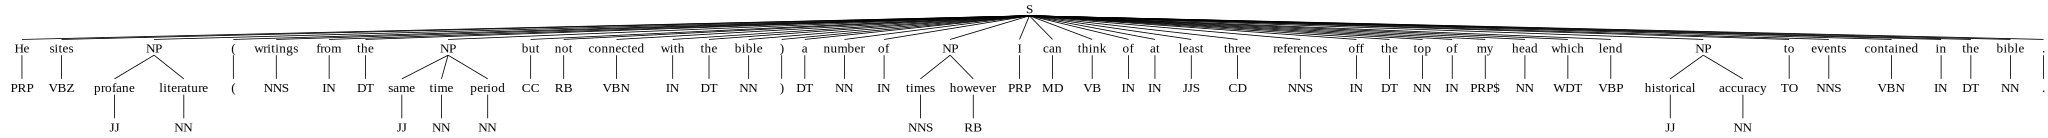

In [18]:
display(movie_reviews.np_chunked[544][3])

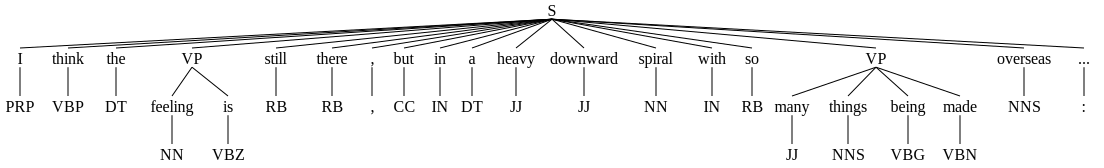

In [19]:
display(movie_reviews.vp_chunked[44][7])

In [20]:
stop_words = set(stopwords.words('english'))
custom_stop_words = ['anyone', 'goes', 'give', 'make', 'made', 'get', 'going', 'gets', 'better', 'done', 'worse', 'everyone', 'great', 'even', 'someone', 'n\'t', 'something', 'best', 'worst', 'anything', 'everything', 'nothing', 'worth', 'years', 'year', 'people', 'movie', 'one', 'story', 'plot', 'film', 'films', 'good', 'really', 'first', '*', 'thing', 'many', 'much', 'really', 'things', 'last', 'next', 'main', 'bad', 'long', 'bit', 'second', 'several', 'lot', 'named', 'seem', 'seemed', 'seems', 'Everyone', 'Go', 'IT']
stop_words = stop_words.union(custom_stop_words)

In [21]:
def chunk_counter(column, label, stopwords = []):
    word_freq = nltk.FreqDist()
    for review in column:
        for tree in review:
            for chunk in tree.subtrees(lambda node: 
                    node.label() == label
                    and sum([word in stopwords for (word, tag) in node.leaves()]) == 0):
                word_freq[str(chunk.flatten())] += 1
    return word_freq

In [22]:
chunk_counter(movie_reviews.np_chunked, 'NP', stop_words).most_common(50)

[('(NP special/JJ effects/NNS)', 1284),
 ('(NP New/NNP York/NNP)', 634),
 ('(NP real/JJ life/NN)', 622),
 ('(NP character/NN development/NN)', 431),
 ('(NP low/JJ budget/NN)', 390),
 ('(NP big/JJ fan/NN)', 360),
 ('(NP young/JJ man/NN)', 360),
 ('(NP high/JJ school/NN)', 358),
 ('(NP big/JJ screen/NN)', 337),
 ('(NP young/JJ woman/NN)', 290),
 ('(NP camera/NN work/NN)', 285),
 ('(NP TV/NN series/NN)', 279),
 ('(NP subject/JJ matter/NN)', 269),
 ('(NP production/NN values/NNS)', 267),
 ('(NP old/JJ man/NN)', 254),
 ('(NP little/JJ girl/NN)', 248),
 ('(NP action/NN scenes/NNS)', 248),
 ('(NP United/NNP States/NNPS)', 243),
 ('(NP young/JJ girl/NN)', 239),
 ('(NP horror/NN movies/NNS)', 236),
 ('(NP fight/NN scenes/NNS)', 224),
 ('(NP final/JJ scene/NN)', 223),
 ('(NP huge/JJ fan/NN)', 219),
 ('(NP small/JJ town/NN)', 216),
 ('(NP serial/JJ killer/NN)', 207),
 ('(NP TV/NN show/NN)', 205),
 ('(NP sex/NN scenes/NNS)', 201),
 ('(NP Star/NNP Wars/NNP)', 200),
 ('(NP video/NN store/NN)', 191),

In [23]:
chunk_counter(movie_reviews.vp_chunked, 'VP', stop_words).most_common(50)

[('(VP happy/JJ ending/VBG)', 183),
 ('(VP time/NN watching/VBG)', 120),
 ('(VP pun/NN intended/VBN)', 64),
 ('(VP cast/NN includes/VBZ)', 59),
 ('(VP life/NN watching/VBG)', 50),
 ('(VP familiar/JJ faces/VBZ)', 49),
 ('(VP end/NN credits/VBZ)', 49),
 ('(VP actor/NN playing/VBG)', 47),
 ('(VP Simply/NNP put/VBD)', 46),
 ('(VP old/JJ fashioned/VBN)', 45),
 ('(VP character/NN played/VBN)', 44),
 ('(VP cult/NN following/VBG)', 43),
 ('(VP cheap/JJ looking/VBG)', 43),
 ('(VP actors/NNS playing/VBG)', 42),
 ('(VP middle/JJ aged/VBN)', 42),
 ('(VP action/NN takes/VBZ)', 41),
 ('(VP God/NNP knows/VBZ)', 36),
 ('(VP actors/NNS look/VBP)', 35),
 ('(VP scenes/NNS involving/VBG)', 33),
 ('(VP predictable/JJ ending/VBG)', 33),
 ('(VP heavy/JJ handed/VBN)', 33),
 ('(VP Highly/NNP recommended/VBD)', 33),
 ('(VP minute/NN running/VBG)', 32),
 ('(VP action/NN packed/VBD)', 31),
 ('(VP fun/NN watching/VBG)', 31),
 ('(VP surprise/NN ending/VBG)', 29),
 ('(VP actress/NN playing/VBG)', 29),
 ('(VP award/N